In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import getpass
import csv

import matplotlib.pyplot as plt


## 1. Extract mortality

#### Alternative 1: sqlite3

In [ ]:
# import sqlite3

# ##############################################################################
# ####################### CONNECT TO MIMIC #####################################
# connection = sqlite3.connect("C:\\Users\\Maria\\Desktop\\Projects Data Scripts\\MIMIC\\data\\mimic3.db")

# #We can verify we successfully created our connection object by running:
# print(connection.total_changes)
# # Be sure to close the connection
# #con.close()

# # Create our test query
# test_query = """
# SELECT subject_id, hadm_id, admittime, dischtime, admission_type, diagnosis
# FROM admissions
# """

# # Run the query and assign the results to a variable
# test = pd.read_sql_query(test_query,connection)

# print("TEST:", test.head())
# ##############################################################################
# ##################### QUERYING, MORTALITY COHORT #############################

# query = """

# WITH icu_patients AS
# (
# SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, pat.DOB, pat.gender, icu.intime 
# , (JulianDay(OUTTIME) - JulianDay(INTIME)) as icu_length_of_stay
# , (JulianDay(icu.INTIME) - JulianDay(pat.DOB))/ 364.242 as age
# , adm.hospital_expire_flag , icu.outtime 
# , RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order 


# FROM icustays icu
# INNER JOIN patients pat
#   ON icu.subject_id = pat.subject_id
# INNER JOIN admissions adm
#     ON adm.subject_id = icu.subject_id
#     AND adm.hadm_id = icu.hadm_id
# )


# SELECT
#     fa.subject_id, fa.hadm_id, fa.icustay_id, fa.icustay_id_order, fa.intime as icu_intime, fa.outtime as icu_outtime, fa.DOB, fa.GENDER, fa.age as patient_age, fa.hospital_expire_flag as mortality, fa.icu_length_of_stay
#   , CASE 
#         WHEN fa.icu_length_of_stay < 2 then 1
#     ELSE 0 END
#         as exclusion_los
#   , CASE
#         WHEN fa.age < 18 then 1
#     ELSE 0 END
#         as exclusion_age
# FROM icu_patients fa

# """

# icu = pd.read_sql_query(query, connection)

In [ ]:
# mortality_cohort = icu.copy()

#### Alternative 2: PostgreSQL

In [2]:
# Set up postgres connection
conn = psycopg2.connect(
    database='mimic', 
    user='zhwa9764', 
    password=getpass.getpass("Enter postgres password"), 
    host='127.0.0.1', 
    port='5432',
    options=f'-c search_path=mimiciii')

Enter postgres password········


In [3]:
##################### QUERYING, MORTALITY COHORT #############################
query = """
WITH icu_patients AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, pat.DOB, pat.gender, icu.intime 
, DATE_PART('day', OUTTIME - INTIME) as icu_length_of_stay
, DATE_PART('day', icu.INTIME - pat.DOB) / 364.242 as age
, adm.hospital_expire_flag , icu.outtime 
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order 
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
    ON adm.subject_id = icu.subject_id
    AND adm.hadm_id = icu.hadm_id
)
SELECT
    fa.subject_id, fa.hadm_id, fa.icustay_id, fa.icustay_id_order, fa.intime as icu_intime, fa.outtime as icu_outtime, fa.DOB, fa.GENDER, fa.age as patient_age, fa.hospital_expire_flag as mortality, fa.icu_length_of_stay
  , CASE 
        WHEN fa.icu_length_of_stay < 2 then 1
    ELSE 0 END
        as exclusion_los
  , CASE
        WHEN fa.age < 18 then 1
    ELSE 0 END
        as exclusion_age
FROM icu_patients fa
"""

mortality_cohort = pd.read_sql(query, conn)

### Data preprocessing

In [4]:
mortality_cohort.shape

(61532, 13)

In [ ]:
mortality_cohort.head()

In [ ]:
pd.value_counts(mortality_cohort['hadm_id']) # same addmission ids occured more than once: (one admission id could be link to mutiple icu stays)

### Extract only the adults, and stay length larger than 1 day

In [7]:
adults = mortality_cohort[mortality_cohort['exclusion_age'] == 0]

adults = adults.loc[adults['icu_length_of_stay'] >= 1]

In [8]:
adults.shape

(45256, 13)

In [ ]:
adults.head()

In [10]:
pd.value_counts(adults['mortality'])

0    39895
1     5361
Name: mortality, dtype: int64

In [11]:
# check if there is any duplicate in the table
sum(adults.duplicated())

0

### Filter to get positive and negative mortality patients separately

In [ ]:
# select the max of icustay order (last admission stay) with the positive mortality 
# pos_filter = adults[adults['mortality']==1].groupby(['subject_id'])['icustay_id_order'].idxmax() 
patient_mortality = (adults.groupby(['subject_id'])['mortality'].max() == 1).reset_index()
pos_patient_set = set(patient_mortality[patient_mortality['mortality']==True]['subject_id'])

pos_filter = adults[adults['subject_id'].isin(pos_patient_set)].groupby(['subject_id'])['icustay_id_order'].idxmax() 
pos_adults = adults.loc[pos_filter]

pos_adults.head()

In [13]:
pos_adults.shape

(4774, 13)

In [14]:
pos_adm_set = set(pos_adults['hadm_id'])

In [ ]:
# select the mix of icustay order (first admission stay) with the negative mortality 
# neg_filter = adults[adults['mortality']==0].groupby(['subject_id'])['icustay_id_order'].idxmin() 

neg_patient_set = set(patient_mortality[patient_mortality['mortality']==False]['subject_id'])

neg_filter = adults[adults['subject_id'].isin(neg_patient_set)].groupby(['subject_id'])['icustay_id_order'].idxmin() 
neg_adults = adults.loc[neg_filter]

neg_adults.head()

In [16]:
neg_adults.shape

(28790, 13)

In [ ]:
pd.value_counts(neg_adults['hadm_id'])

In [18]:
neg_adm_set = set(neg_adults['hadm_id'])

#### Check if there is any patient appearing in both negative or positive sets

In [19]:
set1 = set(pos_adults['subject_id'].reset_index(drop=True))
set2 = set(neg_adults['subject_id'].reset_index(drop=True))

In [20]:
len(list(set1 & set2))

0

## 2. Get clinical texts

In [ ]:
texts = pd.read_sql(
    """
    SELECT hadm_id, subject_id, chartdate, category, description, text
    FROM noteevents;
    """, conn)

texts.head()

In [23]:
texts.shape

(2083180, 6)

In [24]:
pd.value_counts(texts['category'])

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: category, dtype: int64

In [ ]:
category_set = {'Nursing/other', 'Radiology', 'Nursing', 'ECG', 'Physician '}

filtered_texts = texts[texts['category'].isin(category_set)]
filtered_texts.head()

(array([4.2615e+04, 2.3260e+03, 6.1300e+02, 2.4000e+02, 1.1700e+02,
        5.7000e+01, 3.6000e+01, 1.8000e+01, 7.0000e+00, 7.0000e+00]),
 array([1.0000e+00, 1.2040e+02, 2.3980e+02, 3.5920e+02, 4.7860e+02,
        5.9800e+02, 7.1740e+02, 8.3680e+02, 9.5620e+02, 1.0756e+03,
        1.1950e+03]),
 <BarContainer object of 10 artists>)

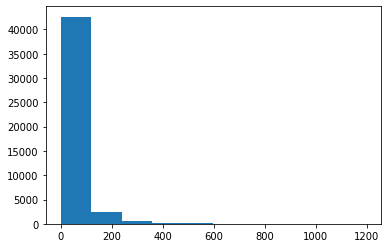

In [60]:
plt.hist(filtered_texts.groupby('subject_id')['category'].count())

In [27]:
pd.value_counts(filtered_texts['category'])

Nursing/other    822497
Radiology        522279
Nursing          223556
ECG              209051
Physician        141624
Name: category, dtype: int64

In [ ]:
filtered_texts.loc[1671084, :]

In [105]:
texts_by_adm_sbj = filtered_texts.groupby(['subject_id', 'hadm_id']).apply(lambda x: x['text'])
texts_by_adm_sbj = texts_by_adm_sbj.reset_index(level=[2], drop=True)

In [ ]:
joined_texts = texts_by_adm_sbj.reset_index().groupby(['subject_id', 'hadm_id'])['text'].apply(lambda x: ','.join(x)).reset_index()

joined_texts.head()

In [127]:
joined_texts.shape

(58006, 3)

In [128]:
pos_texts = joined_texts[joined_texts['hadm_id'].isin(pos_adm_set)]
pos_texts['mortality'] = [1 for i in range(pos_texts.shape[0])]

neg_texts = joined_texts[joined_texts['hadm_id'].isin(neg_adm_set)]
neg_texts['mortality'] = [0 for i in range(neg_texts.shape[0])]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [129]:
pos_texts.shape

(4602, 4)

In [130]:
neg_texts.shape

(28639, 4)

In [ ]:
concat_texts = pd.concat([pos_texts, neg_texts])
concat_texts = concat_texts.sample(frac=1, random_state=39).reset_index(drop=True)
concat_texts

## 3. Text preprocessing

In [ ]:
import re

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [61]:
X = concat_texts['text']

In [ ]:
# Lowercase all the texts
X_lower = X.apply(lambda row: row.lower())
X_lower.head()

In [ ]:
# Remove all the number digits 
X_remove_number = X_lower.apply(lambda row: re.sub(r"\d+", "", row))
X_remove_number.head()

In [ ]:
# Remove all punctuations
X_remove_punct = X_remove_number.apply(lambda row: re.sub(r"\n|_+", " ", row))
X_remove_punct = X_remove_punct.apply(lambda row: re.sub(r"[^\w\s]", "", row))
X_remove_punct.head()

In [ ]:
# Remove all stopwords
X_remove_stop = X_remove_punct.apply(lambda row: " ".join([word for word in row.split() if word not in stop]))
X_remove_stop.head()

In [160]:
X_remove_stop = X_remove_stop.reset_index()

In [ ]:
X_remove_stop

In [162]:
X_remove_stop['length'] = X_remove_stop['text'].apply(lambda row: len(row.split()))

In [169]:
X_remove_stop['length'].describe()

count     33241.000000
mean       4674.802022
std       11332.851955
min           6.000000
25%         796.000000
50%        1686.000000
75%        4271.000000
max      345083.000000
Name: length, dtype: float64

In [ ]:
final_texts = X_remove_stop.join(concat_texts[['subject_id', 'hadm_id', 'mortality']])
final_texts.head()

In [165]:
final_texts = final_text.drop(['index', 'length'], axis=1)

In [ ]:
final_texts

In [167]:
final_texts.to_csv('./texts.csv')